In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch 10. Iris 다중분류</font><b>

In [7]:
import os # 모델 저장할 폴더 확인 / 폴더 생성
import numpy as np
import pandas as pd # get_dummies, crosstab
import seaborn as sns # iris 데이터(df) 가져오기
from sklearn import datasets # iris 데이터(X, y) 가져오기
from sklearn.preprocessing import LabelEncoder # 라벨인코딩
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

- 데이터셋 생성(seaborn) & 전처리
    - X, y(라벨인코딩-원핫인코딩) 분리 → train셋과 test셋 분리(8:2)
- 모델 구성(입력4 → 출력3, layer5: 4→64→128→60→30→3)
- 모델 학습과정 설정
- 모델 학습(earlystopping, modelcheckpoint 추가)
- 모델 평가(시각화, 최종모델/저장모델 evaluate, 교차표)

# 1. 스케일링 없이

## 1.1. 데이터셋

In [9]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [12]:
# 독립변수 종속변수 분리
X_iris = iris.iloc[:, :-1].values #2차원 np array
le = LabelEncoder()
y_iris = le.fit_transform(iris.iloc[:, -1]) #2차원 np array + 라벨인코딩
# 0: setosa, 1: versicolor, 2:virginica
X_iris.shape, y_iris.shape

((150, 4), (150,))

In [15]:
# 종속변수 원핫인코딩
Y_iris = to_categorical(y_iris)
Y_iris.shape

(150, 3)

In [17]:
# 훈련셋 검증셋 분리
X_train, X_test, Y_train, Y_test = train_test_split(X_iris, Y_iris, 
                                                    train_size=0.8, 
                                                    stratify=Y_iris, #층화 추출
                                                    random_state=3)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

## 1.2. 모델 구성

In [18]:
model = Sequential()
#4→64→128→60→30→3
model.add(Input(4))
model.add(Dense(64, 'relu'))
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(60))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(30, 'relu'))
model.add(Dense(3, 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 60)                7740      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 3)                 9

In [19]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [20]:
model_save_folder = './model10/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = file,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max',
                verbose=0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

## 1.3. 모델 학습

In [22]:
hist = model.fit(X_train, Y_train, 
                 epochs=200, 
                 batch_size=100, 
                 validation_split=0.2, 
                 verbose=1, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/200
1/1 [==============================] - 1s 566ms/step - loss: 1.1425 - accuracy: 0.6250 - val_loss: 1.0652 - val_accuracy: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 22ms/step - loss: 1.0754 - accuracy: 0.4583 - val_loss: 1.0168 - val_accuracy: 0.3750
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 1.0271 - accuracy: 0.4062 - val_loss: 0.9837 - val_accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 45ms/step - loss: 0.9927 - accuracy: 0.3333 - val_loss: 0.9560 - val_accuracy: 0.5417
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.9632 - accuracy: 0.4792 - val_loss: 0.9318 - val_accuracy: 0.6250
Epoch 6/200
1/1 [==============================] - 0s 41ms/step - loss: 0.9387 - accuracy: 0.6250 - val_loss: 0.9050 - val_accuracy: 0.6667
Epoch 7/200
1/1 [==============================] - 0s 42ms/step - loss: 0.9124 - accuracy: 0.5938 - val_loss: 0.8759 - val_accuracy: 0.8750
Epoch 8/200
1/1 [==

1/1 [==============================] - 0s 27ms/step - loss: 0.0843 - accuracy: 0.9792 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 60/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0817 - accuracy: 0.9792 - val_loss: 0.0482 - val_accuracy: 1.0000
Epoch 61/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0793 - accuracy: 0.9792 - val_loss: 0.0461 - val_accuracy: 1.0000
Epoch 62/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0770 - accuracy: 0.9792 - val_loss: 0.0443 - val_accuracy: 1.0000
Epoch 63/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0749 - accuracy: 0.9792 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 64/200
1/1 [==============================] - 0s 21ms/step - loss: 0.0730 - accuracy: 0.9792 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 65/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0711 - accuracy: 0.9792 - val_loss: 0.0392 - val_accuracy: 1.0000
Epoch 66/200
1/1 [========

1/1 [==============================] - 0s 16ms/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 118/200
1/1 [==============================] - 0s 19ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 119/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0337 - accuracy: 0.9792 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 120/200
1/1 [==============================] - 0s 18ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 121/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0333 - accuracy: 0.9792 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 122/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 123/200
1/1 [==============================] - 0s 19ms/step - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 124/200
1/1 [=

## 1.4. 모델 평가

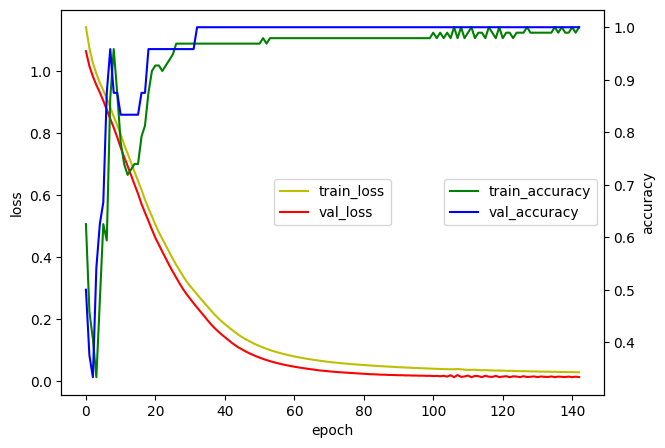

In [23]:
# 시각화
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [24]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss: {loss_and_acc[0]:.4f}, accuracy: {loss_and_acc[1]:.4f}')

loss: 0.1917, accuracy: 0.9667


In [25]:
# 저장 모델과 비교
model1 = load_model('./model10/iris-033-loss0.2372-acc1.0000.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss: {loss_and_acc1[0]:.4f}, accuracy: {loss_and_acc1[1]:.4f}')

loss: 0.2727, accuracy: 0.9667


In [26]:
# 모델 저장
model.save('model10/iris.h5')

In [27]:
# 교차표 (실제값과 예측값)
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test), axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['pred'])

1/1 [==============================] - 0s 81ms/step


pred,0,1,2
real,,,
0,10,0,0
1,0,9,1
2,0,0,10


In [30]:
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
33,5.5,4.2,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
129,7.2,3.0,5.8,1.6,virginica
67,5.8,2.7,4.1,1.0,versicolor
100,6.3,3.3,6.0,2.5,virginica


In [31]:
input_data = [[5.5, 4.2, 1.4, 0.2], #setosa (0)
              [5.8, 2.7, 4.1, 1.0], #versicolor (1)
              [6.3, 3.3, 6.0, 2.5]] #virginica (2)

In [32]:
model.predict(input_data).argmax(axis=1)

1/1 [==============================] - 0s 43ms/step


array([0, 1, 2], dtype=int64)

# 2. Standard Scaler

## 2.1. 데이터셋 (스케일링)

In [34]:
stdScaler = StandardScaler()

In [35]:
std_X = stdScaler.fit_transform(X_iris)

In [36]:
# 훈련셋 검증셋 분리
sX_train, sX_test, Y_train, Y_test = train_test_split(std_X, Y_iris, 
                                                    train_size=0.8, 
                                                    stratify=Y_iris, #층화 추출
                                                    random_state=3)
sX_train.shape, Y_train.shape, sX_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

## 2.2. 모델 구성 (sModel)

In [37]:
sModel = Sequential()
#4→64→128→60→30→3
sModel.add(Input(4))
sModel.add(Dense(64, 'relu'))
sModel.add(Dense(128))
sModel.add(LeakyReLU(alpha=0.01))
sModel.add(Dense(60))
sModel.add(LeakyReLU(alpha=0.01))
sModel.add(Dense(30, 'relu'))
sModel.add(Dense(3, 'softmax'))
sModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 60)                7740      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 30)                1830      
                                                                 
 dense_9 (Dense)             (None, 3)                

In [38]:
sModel.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [39]:
sfile = model_save_folder + 'Std_iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = sfile,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max',
                verbose=0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

## 2.3. 모델 학습

In [43]:
hist = sModel.fit(sX_train, Y_train, 
                 epochs=200, 
                 batch_size=100, 
                 validation_split=0.2, 
                 verbose=0, 
                 callbacks=[checkpoint, earlyStopping])

## 2.4. 모델 평가

In [44]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

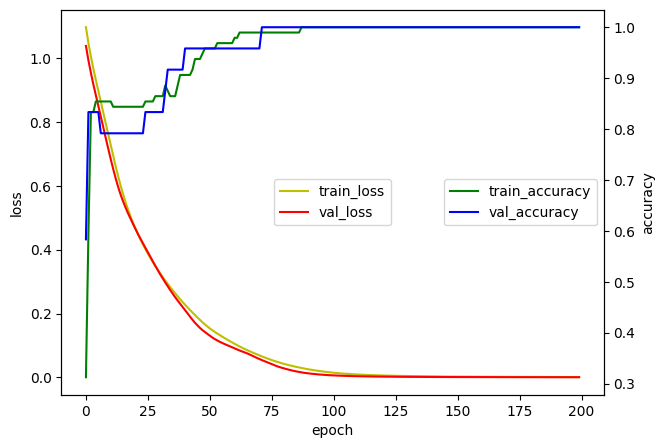

In [45]:
# 시각화
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [46]:
# 모델 평가
loss_and_acc = model.evaluate(sX_test, Y_test, batch_size=100, verbose=0)
print(f'loss: {loss_and_acc[0]:.4f}, accuracy: {loss_and_acc[1]:.4f}')

loss: 0.6304, accuracy: 0.9000


In [47]:
# 저장 모델과 비교
sModel1 = load_model('./model10/Std_iris-007-loss0.1561-acc1.0000.h5')
loss_and_accs1 = sModel1.evaluate(X_test, Y_test, verbose=0)
print(f'loss: {loss_and_accs1[0]:.4f}, accuracy: {loss_and_accs1[1]:.4f}')

loss: 1.3094, accuracy: 0.7333


In [48]:
# 모델 저장
sModel.save('model10/iris_Std.h5')

In [49]:
# 교차표 (실제값과 예측값)
real = np.argmax(Y_test, axis=1)
pred = np.argmax(sModel.predict(sX_test), axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['pred'])

1/1 [==============================] - 0s 50ms/step


pred,0,1,2
real,,,
0,10,0,0
1,0,8,2
2,0,1,9


In [52]:
scaled_data = stdScaler.transform(input_data)
scaled_data

array([[-0.41600969,  2.63038172, -1.34022653, -1.3154443 ],
       [-0.05250608, -0.82256978,  0.194384  , -0.26238682],
       [ 0.55333328,  0.55861082,  1.27429511,  1.71209594]])

In [53]:
sModel.predict(scaled_data).argmax(axis=1)

1/1 [==============================] - 0s 20ms/step


array([0, 1, 2], dtype=int64)

# 3. MinMaxScaler

## 3.1. 데이터셋 (스케일링)

In [54]:
mScaler = MinMaxScaler()

In [55]:
mX = mScaler.fit_transform(X_iris)

In [56]:
# 훈련셋 검증셋 분리
mX_train, mX_test, Y_train, Y_test = train_test_split(mX, Y_iris, 
                                                    train_size=0.8, 
                                                    stratify=Y_iris, #층화 추출
                                                    random_state=3)
mX_train.shape, Y_train.shape, mX_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

## 3.2. 모델 구성 (mModel)

In [71]:
mModel = Sequential()
#4→64→128→60→30→3
mModel.add(Input(4))
mModel.add(Dense(64, 'relu'))
mModel.add(Dense(128))
mModel.add(LeakyReLU(alpha=0.01))
mModel.add(Dense(60))
mModel.add(LeakyReLU(alpha=0.01))
mModel.add(Dense(30, 'relu'))
mModel.add(Dense(3, 'softmax'))
mModel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                320       
                                                                 
 dense_21 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 60)                7740      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 60)                0         
                                                                 
 dense_23 (Dense)            (None, 30)                1830      
                                                                 
 dense_24 (Dense)            (None, 3)                

In [72]:
mModel.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [73]:
mfile = model_save_folder + 'm_iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = mfile,
                monitor='val_accuracy',
                save_best_only=True,
                mode = 'max',
                verbose=0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

## 3.3. 모델 학습

In [74]:
hist = mModel.fit(mX_train, Y_train, 
                 epochs=200, 
                 batch_size=100, 
                 validation_split=0.2, 
                 verbose=0, 
                 callbacks=[checkpoint, earlyStopping])

## 3.4. 모델 평가

In [75]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

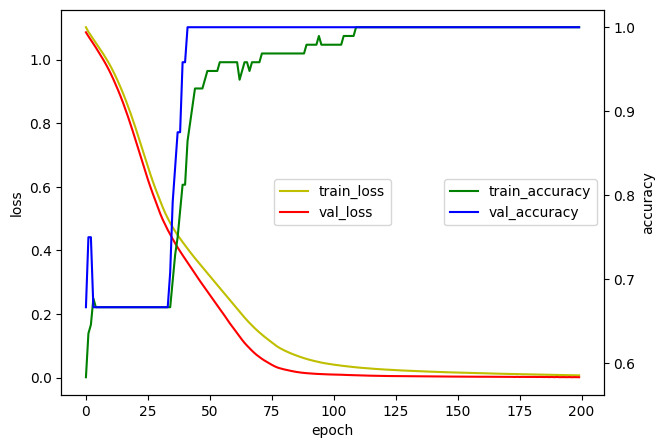

In [76]:
# 시각화
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [64]:
# 모델 평가
loss_and_acc = mModel.evaluate(mX_test, Y_test, batch_size=100, verbose=0)
print(f'loss: {loss_and_acc[0]:.4f}, accuracy: {loss_and_acc[1]:.4f}')

loss: 0.2721, accuracy: 0.9333


In [77]:
# 저장 모델과 비교
mModel1 = load_model('./model10/m_iris-042-loss0.3622-acc1.0000.h5')
loss_and_accs1 = mModel1.evaluate(X_test, Y_test, verbose=0)
print(f'loss: {loss_and_accs1[0]:.4f}, accuracy: {loss_and_accs1[1]:.4f}')

loss: 0.2263, accuracy: 0.9667


In [82]:
# 모델 저장
mModel.save('model10/iris_MinMax_.h5')
mModel1.save('model10/iris_MinMax.h5')

In [79]:
# 교차표 (실제값과 예측값)
real = np.argmax(Y_test, axis=1)
pred = np.argmax(mModel1.predict(mX_test), axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['pred'])

1/1 [==============================] - 0s 57ms/step


pred,0,1,2
real,,,
0,10,0,0
1,0,6,4
2,0,0,10


In [80]:
scaled_data = mScaler.transform(input_data)
scaled_data

array([[0.33333333, 0.91666667, 0.06779661, 0.04166667],
       [0.41666667, 0.29166667, 0.52542373, 0.375     ],
       [0.55555556, 0.54166667, 0.84745763, 1.        ]])

In [81]:
mModel1.predict(scaled_data).argmax(axis=1)

1/1 [==============================] - 0s 21ms/step


array([0, 1, 2], dtype=int64)